In order to determine what, if any impact population has on bus stop ridership, we first need a measure of population for each stop. In order to calculate population by bus stop we'll use a 400m circular buffer for each stop and sum the populations of the Dissemination Area representative points that fall within that buffer.

First we load a few basic libraries for working wiith spatial data.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

Next we load the BC Dissemination Block attributes and create point geometries from their representative points. The geometries are projected from Stats Canada Lambert (EPSG:3347) to BC Albers (EPSG:3005).

In [2]:
pop_data = pd.read_csv('./Data/DB_attr/BC_DB_attr.csv')
pop_data['geometry'] = [Point(db[9],db[10]) for db in pop_data.itertuples()]

sp_pop_data = gpd.GeoDataFrame(pop_data)
sp_pop_data.crs = {'init' :'epsg:3347'}
sp_pop_data = sp_pop_data.to_crs({'init': 'epsg:3005'})

Then we load the bus stop locations and create point geometries from their lat long pairs. The geometries are projected from WGS 84 (EPSG:4326) to BC Albers (EPSG:3005).

In [3]:
stop_data = pd.read_csv('./Data/StopLocations/stops.txt')
stop_data['geometry'] = [Point(stop[4],stop[3]) for stop in stop_data.itertuples()]

sp_stop_data = gpd.GeoDataFrame(stop_data)
sp_stop_data.crs = {'init': 'epsg:4326'}
sp_stop_data = sp_stop_data.to_crs({'init' :'epsg:3005'})

Now we can create a 400m buffer of each one the stop locations and do a  spatial join to determine the population within 400m of the stop.

In [4]:
buffered_stops = sp_stop_data
buffered_stops.geometry = buffered_stops.geometry.buffer(400)
stops_with_pop = gpd.sjoin(buffered_stops,sp_pop_data, how='left')
pop_by_stopid = stops_with_pop.groupby('stop_id').sum()[' DBpop2016/IDpop2016']
stop_data = stop_data.join(pop_by_stopid, on='stop_id')
stop_data['population'] = stop_data[' DBpop2016/IDpop2016']

Now we can do some quick exploration on the dataset.

count    2322.000000
mean     1107.595607
std      1044.342518
min         0.000000
25%         0.000000
50%       960.000000
75%      1652.000000
max      5671.000000
Name: population, dtype: float64


(0, 6729.1552150368698)

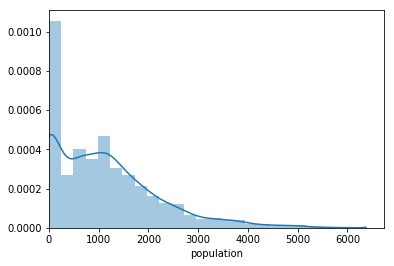

In [5]:
print(stop_data.population.describe())
hist = sns.distplot(stop_data.population)
hist.set_xlim(left=0)

Top Ten(by population)

In [6]:
stop_data.sort_values('population', ascending=False).head(10)[['stop_id','stop_name','population']]

,stop_id,stop_name,population
65,100069,Northbound Quadra at View,5671.0
33,100036,Southbound Menzies at Simcoe,5537.0
103,100112,Southbound Cook at Rockland,5331.0
66,100070,Eastbound Fairfield at Vancouver,5303.0
46,100049,Westbound Niagara at Medana,4998.0
49,100052,Eastbound Niagara at Medana,4998.0
89,100096,Southbound Cook at Richardson,4980.0
28,100031,Northbound Menzies at Simcoe,4979.0
19,100022,Southbound Menzies at Michigan,4966.0
106,100115,Southbound Cook at Pandora,4961.0


Stops with zero population catchement

In [7]:
stop_data.loc[stop_data.population==0]

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,geometry,DBpop2016/IDpop2016,population
7,100009,Southbound Patrica Bay at Haliburton,48.513950,-123.384455,100009,0,NaN,POINT (-123.384454999615 48.5139499957935),0.0,0.0
14,100016,Eastbound Sooke at Townsend,48.378370,-123.722045,100016,0,NaN,POINT (-123.722044999691 48.3783699951146),0.0,0.0
16,100018,Eastbound 5250 block Sooke,48.389028,-123.642837,100018,0,NaN,POINT (-123.642836999826 48.3890279955025),0.0,0.0
44,100047,Southbound Wharf at Yates,48.427086,-123.370485,100047,0,NaN,POINT (-123.37048499987 48.42708599526879),0.0,0.0
50,100053,Eastbound Johnson at Store,48.427740,-123.369684,100053,0,NaN,POINT (-123.369684000459 48.42773999570829),0.0,0.0
67,100071,Northbound University at Ring,48.460112,-123.314435,100071,0,NaN,POINT (-123.314435285696 48.4601116593775),0.0,0.0
127,100136,Northbound Metchosin at Cotlow,48.414453,-123.483313,100136,0,NaN,POINT (-123.483313388403 48.4144525327798),0.0,0.0
144,100154,Southbound Metchosin at Kenning,48.413932,-123.483561,100154,0,NaN,POINT (-123.483560544155 48.4139322987706),0.0,0.0
147,100157,Swartz Bay Passenger Loop,48.688001,-123.412148,100157,0,NaN,POINT (-123.412147587587 48.6880014248094),0.0,0.0
160,100170,Eastbound Bay at Turner,48.434836,-123.375397,100170,0,NaN,POINT (-123.375397000066 48.4348359953748),0.0,0.0


While quick and easy we can obviously we see that there are several issues with using Dissemination Area representative points. 
1. There are way too many stops with zero population.
2. Areas with high volumes of foot traffic are not represented such as the Downtown Core and the University.
3. Daytime populations and night time populations can be significantly different and Census data typically trends towards night time populations.

In [8]:
sp_db_bounds = gpd.read_file('./Data/DB_shape/BC_DB_shape_2016.shp')

Join the spatial boundaries and the population attributes file

In [9]:
sp_db_bounds['DBUID'] = sp_db_bounds['DBUID'].astype('int64')
sp_pop_data_poly = pd.merge(sp_db_bounds, pop_data, left_on='DBUID', right_on='DBuid/IDidu')

Calculate the Density of people per square kilometer

In [10]:
sp_pop_data_poly['Area'] = [db.geometry_x.area/1000000 for db in sp_pop_data_poly.itertuples()]
sp_pop_data_poly['Population'] = sp_pop_data_poly[' DBpop2016/IDpop2016']
sp_pop_data_poly['Density'] = sp_pop_data_poly.Population/sp_pop_data_poly.Area

Now we find the intersection of the buffered stops and the DB boundaries to determine the area of each DB within 400m of a bus stop

In [11]:
sp_pop_data_poly['geometry'] = sp_pop_data_poly.geometry_x
cap_pop_data_poly = sp_pop_data_poly.loc[sp_pop_data_poly.CDUID=='5917']

In [ ]:
#intersection = gpd.overlay(buffered_stops,cap_pop_data_poly, how='intersection')

In [30]:
spatial_index = buffered_stops.sindex

cap_pop_data_poly.bounds
#possible_matches_index = list(spatial_index.intersection(cap_pop_data_poly.bounds))
#precise_matches = possible_matches[possible_matches_index]
#spatial_index.intersection(cap_pop_[data_poly.bounds.loc[0]
list(spatial_index.intersection(cap_pop_data_poly.bounds.loc[15866]))

[]

In [15]:
spatial_index

AttributeError: 'SpatialIndex' object has no attribute 'loc'